In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [7]:
data_train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
220,221,1,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,NaN,S
110,111,0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0000,C110,S
662,663,0,1,"Colley, Mr. Edward Pomeroy",male,47.0,0,0,5727,25.5875,E58,S
581,582,1,1,"Thayer, Mrs. John Borland (Marian Longstreth M...",female,39.0,1,1,17421,110.8833,C68,C
675,676,0,3,"Edvardsson, Mr. Gustaf Hjalmar",male,18.0,0,0,349912,7.7750,NaN,S
870,871,0,3,"Balkic, Mr. Cerin",male,26.0,0,0,349248,7.8958,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
325,326,1,1,"Young, Miss. Marie Grice",female,36.0,0,0,PC 17760,135.6333,C32,C
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
876,877,0,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,NaN,S


In [ ]:
Обробити дані для подальшого використання у кластеризації (вирішити проблему з missing data, закодувати змінні).

In [9]:
missing_values = data_train.isnull().sum()
print(missing_values) 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [20]:
data_train[data_train.duplicated()] 
# дублікатів немає

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [21]:
# будемо заміняти відсутні значення в стовпці "Age", спираючись на кількість дітей у цього пасажира (поле "Parch")
# так як наявність дітей, скоріш за все, свідчить про більший вік

# створимо новий стовпець, що показує, чи є у пасажира діти
data_train['Has_children'] = np.where(data_train['Parch'] > 0, 1, 0)

# розрахуємо середній вік для кожної групи з дітьми та без дітей
mean_age_children = data_train[data_train['Has_children'] == 1]['Age'].mean()
mean_age_no_children = data_train[data_train['Has_children'] == 0]['Age'].mean()

# функція для заміни відсутніх значень віку залежно від наявності дітей
def impute_age(row):
    if pd.isnull(row['Age']):
        if row['Has_children'] == 1:
            return mean_age_children
        else:
            return mean_age_no_children
    else:
        return row['Age']

# замінемо відсутні значень віку за допомогою нової функції
data_train['Age'] = data_train.apply(impute_age, axis=1)

# видяляємо стовпець
data_train.drop('Has_children', axis=1, inplace=True)

In [30]:
# стовпець "Embarked" вказує на порт посадки пасажира (C = Cherbourg, Q = Queenstown, S = Southampton) 
# оскільки в ньому лише два відсутніх значення, можна замінити їх на найбільш поширений порт посадки серед усіх пасажирів. 
most_common_port = data_train['Embarked'].mode()[0]
data_train['Embarked'] = data_train['Embarked'].fillna(most_common_port)

In [31]:
# стовпець "Cabin" містить багато відсутніх значень (687 із 891), тому його доцільніше просто видалити
data_train.drop('Cabin', axis=1, inplace=True)

In [32]:
missing_values = data_train.isnull().sum()
print(missing_values) 

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [33]:
data_train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
167,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,S
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,S
543,544,1,2,"Beane, Mr. Edward",male,32.0,1,0,2908,26.0000,S
720,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,S
99,100,0,2,"Kantor, Mr. Sinai",male,34.0,1,0,244367,26.0000,S


In [35]:
from sklearn.preprocessing import LabelEncoder

In [36]:
# закодуємо категоріальні змінні "Sex" і "Embarked" у числові формати, щоб наш алгоритм кластеризації міг працювати з цими даними
label_encoder_sex = LabelEncoder()
label_encoder_embarked = LabelEncoder()

data_train['Sex'] = label_encoder_sex.fit_transform(data_train['Sex'])
data_train['Embarked'] = label_encoder_embarked.fit_transform(data_train['Embarked'])

In [39]:
# стовпці з іменами пасажирів і номерами квитків також слід видалити, 
# оскільки вони не несуть корисної інформації для кластеризації
# і не можуть бути коректно перетворені у числовий формат.
data_train.drop('Name', axis=1, inplace=True)
data_train.drop('Ticket', axis=1, inplace=True)

In [41]:
data_train.sample(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
670,671,1,2,0,40.000000,1,1,39.0000,2
856,857,1,1,0,45.000000,1,1,164.8667,2
712,713,1,1,1,48.000000,1,0,52.0000,2
193,194,1,2,1,3.000000,1,1,26.0000,2
495,496,0,3,1,32.178503,0,0,14.4583,0


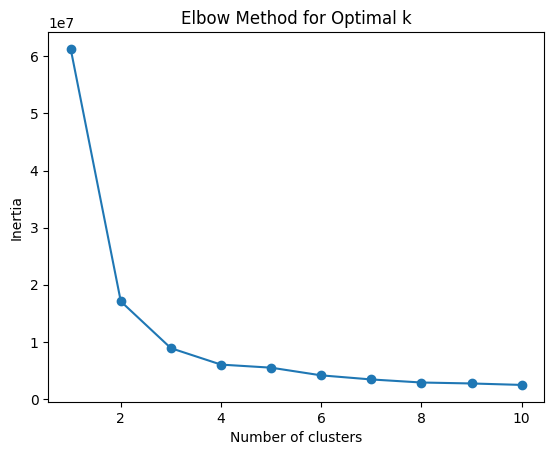

In [42]:
# K-Means метод
from sklearn.cluster import KMeans

# Вибір кількості кластерів
k_values = range(1, 11)
inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_train)
    inertia.append(kmeans.inertia_)

# Побудова графіку "лікоть"
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

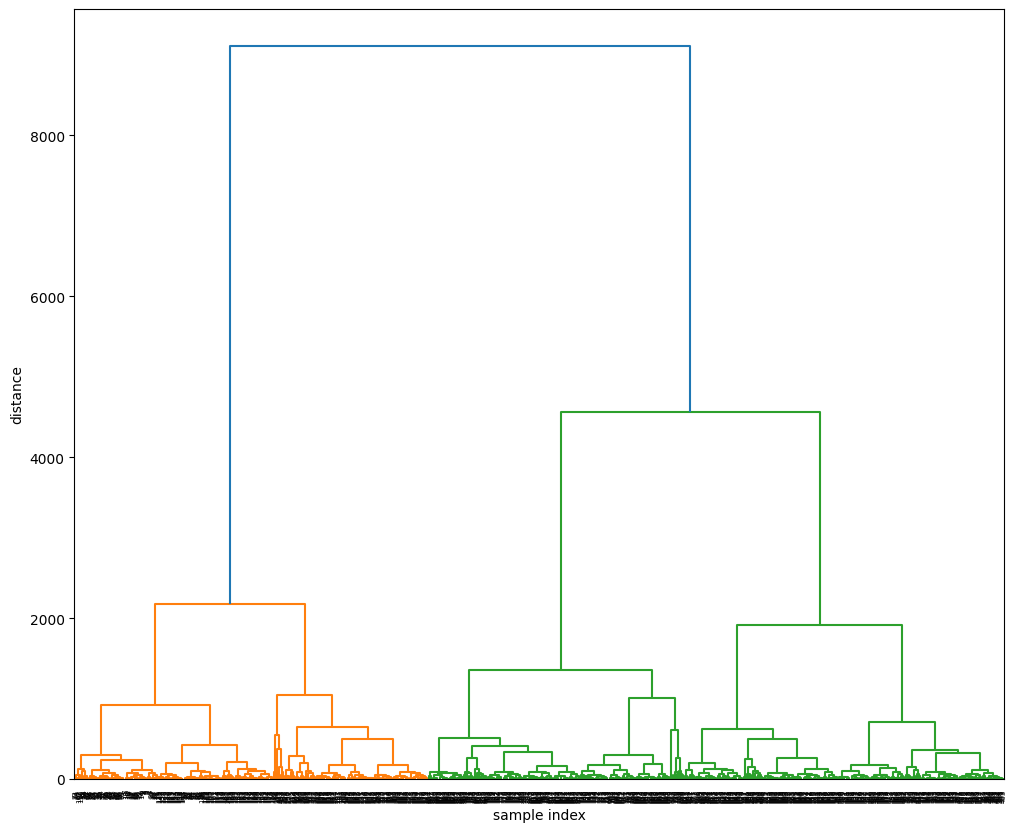

In [46]:
# Ієрархічна кластеризація (ward)
from scipy.cluster.hierarchy import dendrogram, linkage

D_ward = linkage(data_train, method='ward')

# побудуємо дендрограми
plt.figure(figsize=(12, 10))
dendrogram(D_ward)
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()

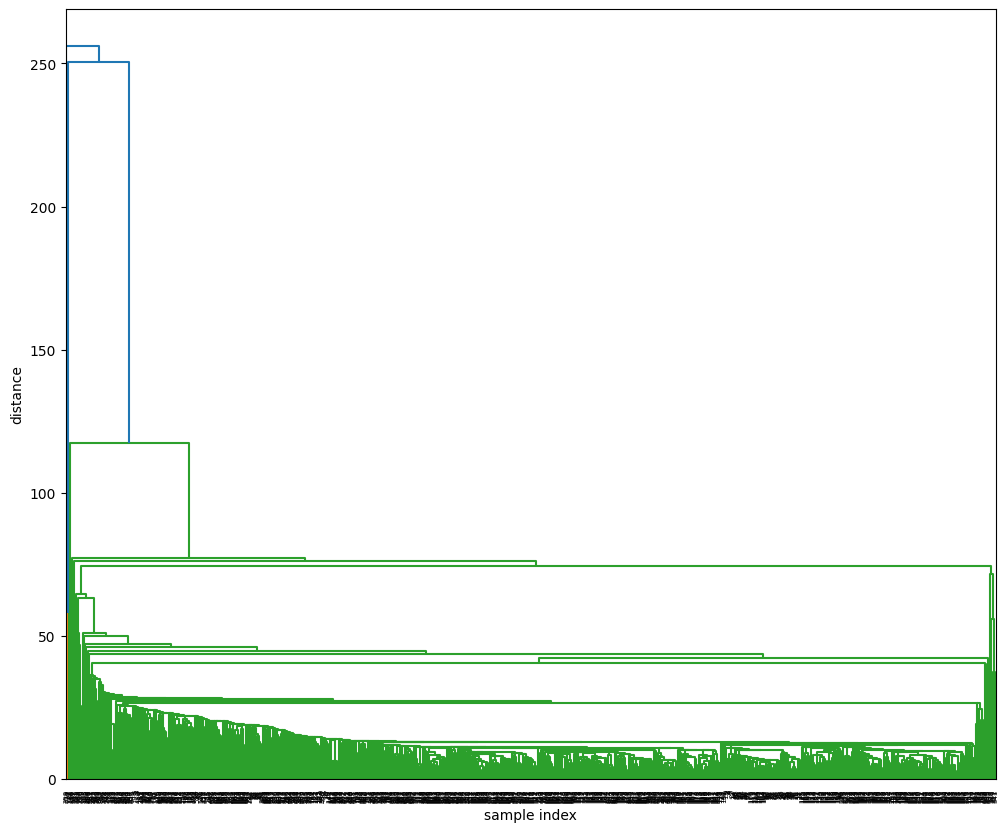

In [48]:
# Ієрархічна кластеризація (single)
D_single = linkage(data_train, method='single')

# побудуємо дендрограми
plt.figure(figsize=(12, 10))
dendrogram(D_single)
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()

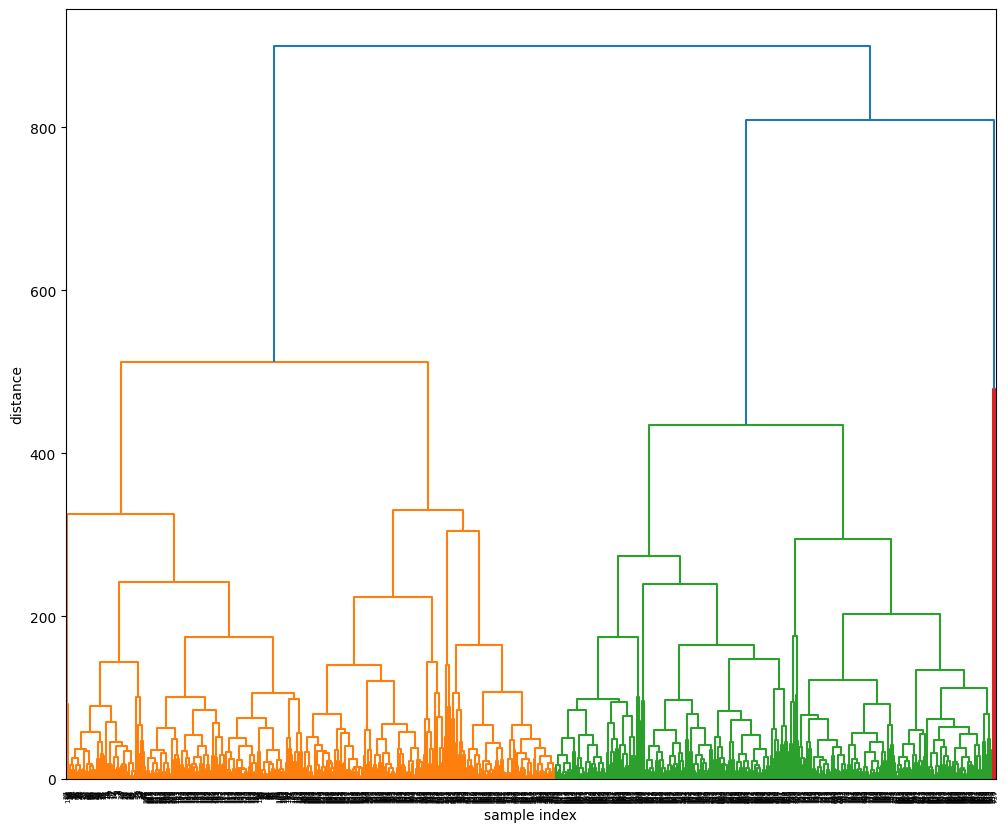

In [49]:
# Ієрархічна кластеризація (complete)
D_complete = linkage(data_train, method='complete')

# побудуємо дендрограми
plt.figure(figsize=(12, 10))
dendrogram(D_complete)
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()

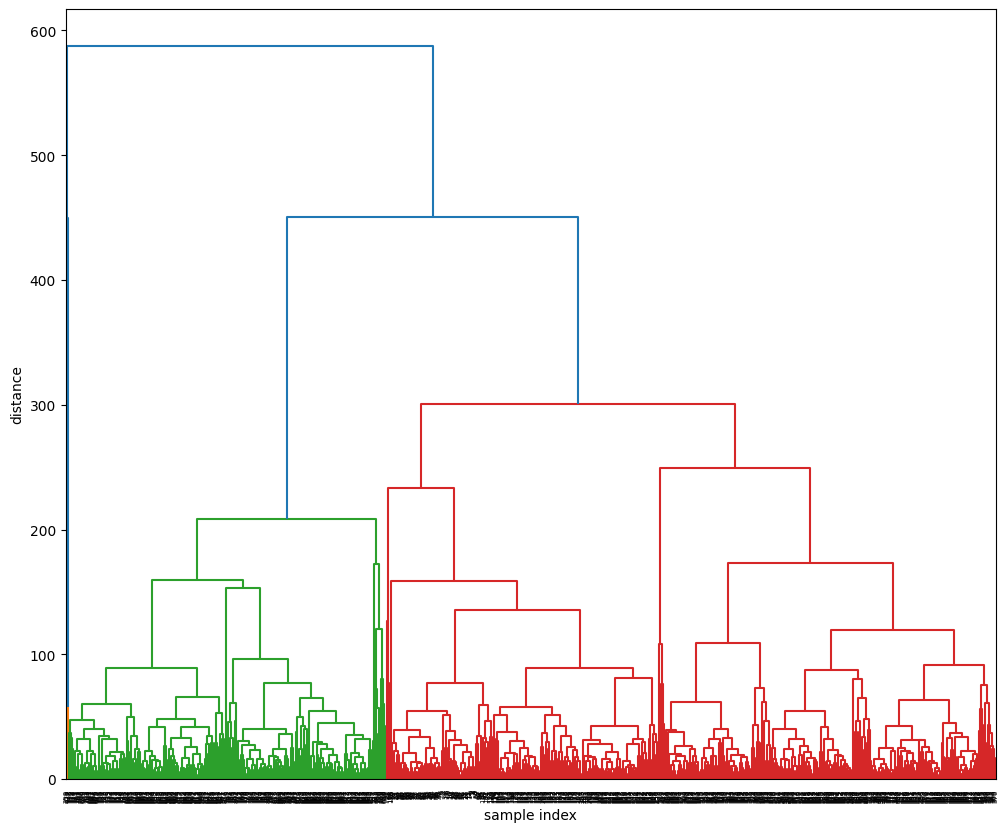

In [50]:
# Ієрархічна кластеризація (average)
D_average = linkage(data_train, method='average')

# побудуємо дендрограми
plt.figure(figsize=(12, 10))
dendrogram(D_average)
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()